In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [2]:
from src.components.speech.read_vocalics_series import read_vocalics_series
from src.components.speech.plot_vocalics_series import plot_vocalic_series

In [3]:
vocalics_series_directory = "/home/soggy/Documents/data/tomcat/vocalics_series"
vocalics_series_data = read_vocalics_series(vocalics_series_directory)

# Analyze a single trial

In [4]:
trial_number = "T000746"

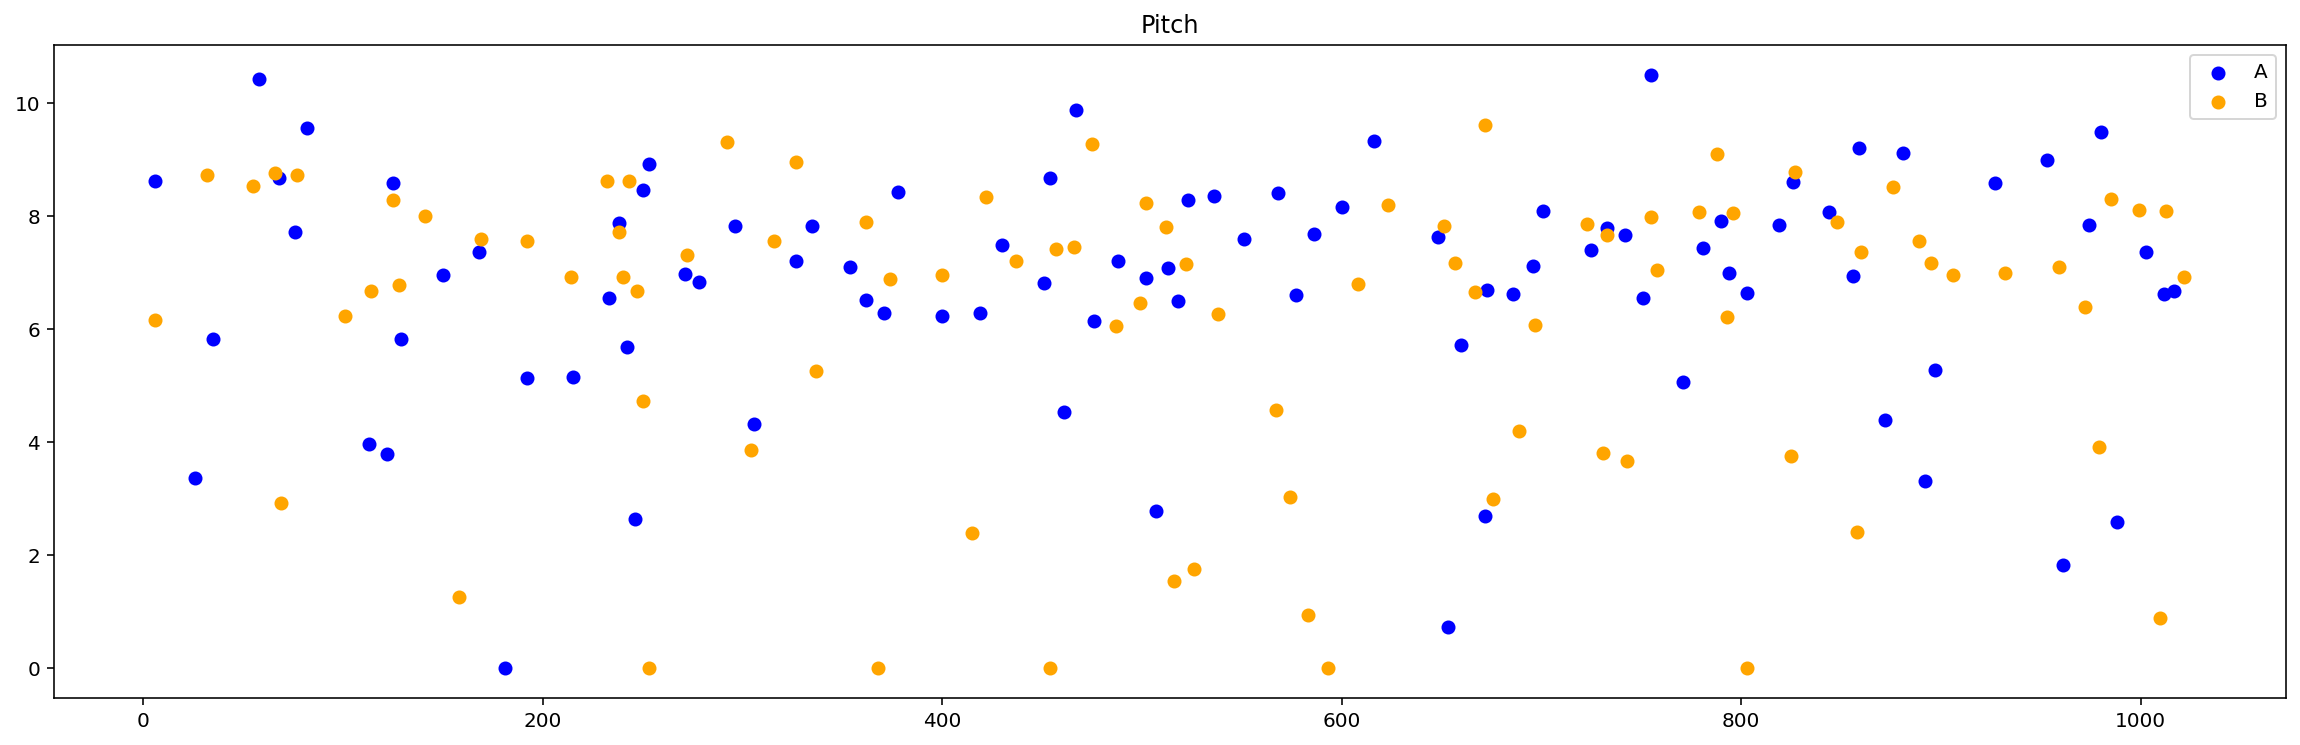

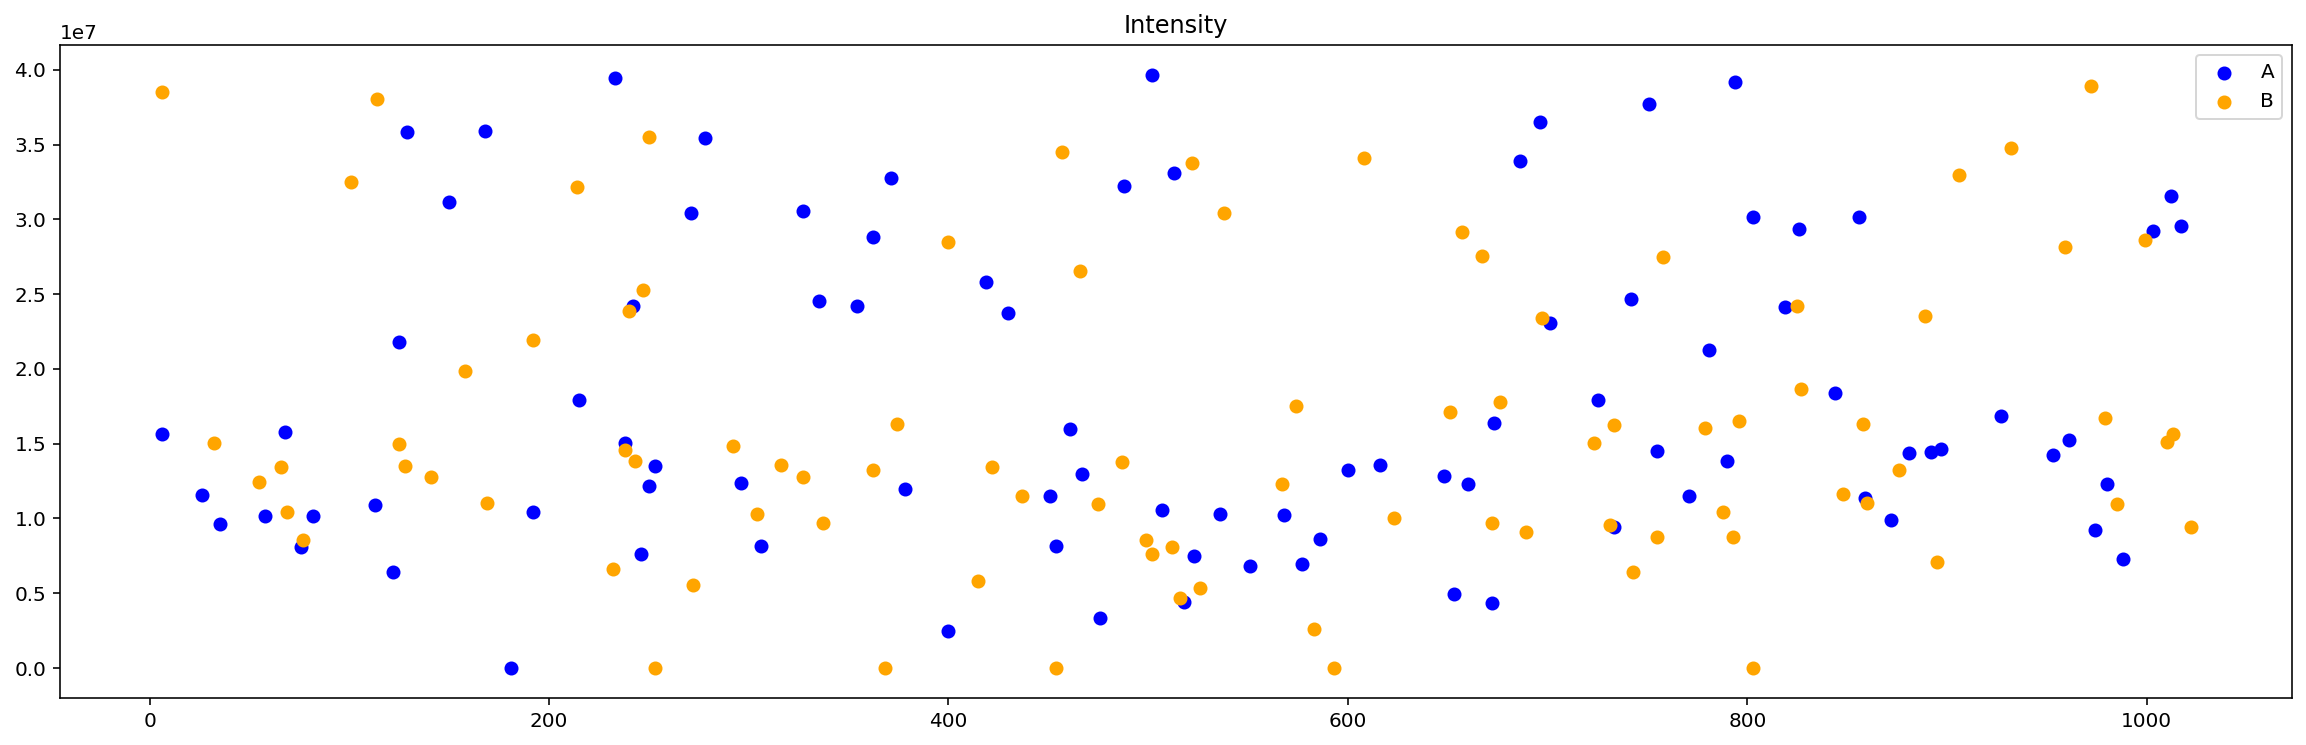

In [5]:
series_a = vocalics_series_data[trial_number]["series_a"]
series_b = vocalics_series_data[trial_number]["series_b"]

ax_pitch = plot_vocalic_series(series_a["pitch"], series_b["pitch"], title="Pitch")
ax_pitch = plot_vocalic_series(series_a["intensity"], series_b["intensity"], title="Intensity")

In [6]:
import numpy as np
from src.inference.vocalics import DiscreteCoordinationInference
from src.transformations.series_transformations import \
    embed_features_across_dimensions

In [7]:
from typing import List

import matplotlib.pyplot as plt


# Plot functions
def plot_coordination(cs: List[float], title: str):
    plt.figure(figsize=(20, 6))
    plt.scatter(range(len(cs)), cs, color="green")
    plt.title(title)
    plt.show()

Team Score: 530


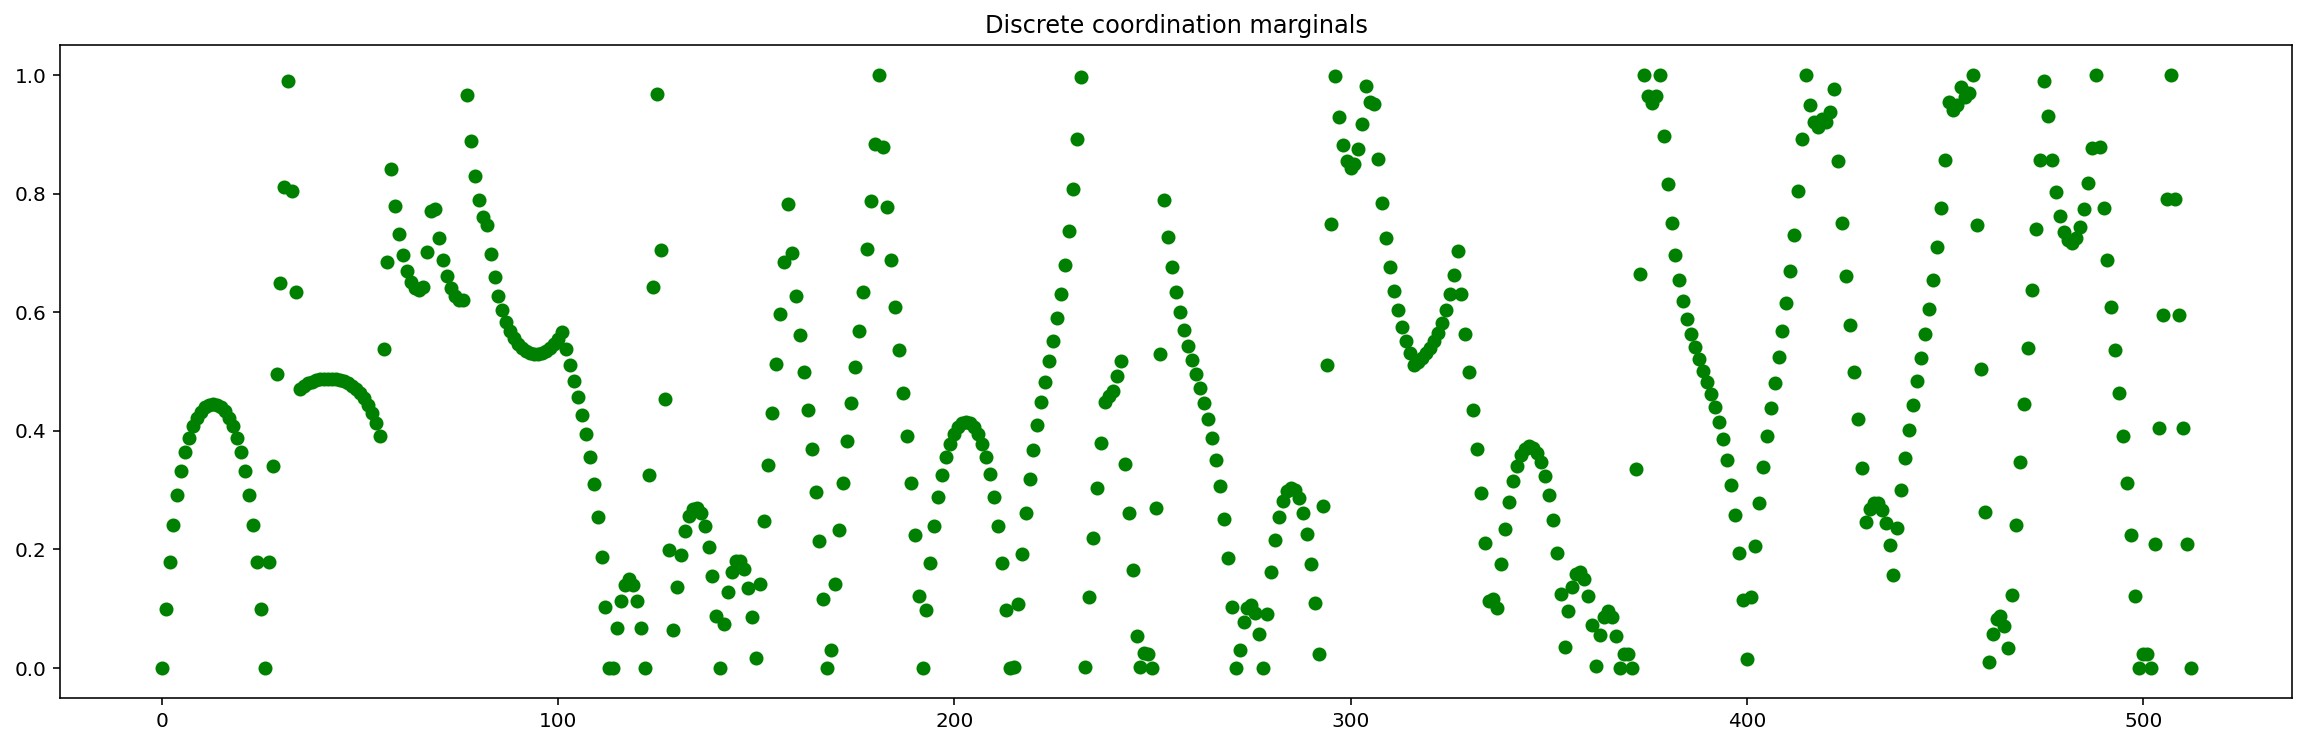

In [8]:
num_timestamps = len(series_a["pitch"])

multi_dim_a, mask_a = embed_features_across_dimensions(num_timestamps, series_a)
multi_dim_b, mask_b = embed_features_across_dimensions(num_timestamps, series_b)

# Normalize series to have mean 0 and std 1
multi_dim_a = (multi_dim_a - np.mean(multi_dim_a, axis=0)) / np.std(multi_dim_a, axis=0)
multi_dim_b = (multi_dim_b - np.mean(multi_dim_b, axis=0)) / np.std(multi_dim_b, axis=0)

inference_engine = DiscreteCoordinationInference(multi_dim_a.T, multi_dim_b.T, 0, 0.9, 0, 1, 0, 1, 1, mask_a, mask_b)
marginals = inference_engine.estimate_marginals()

team_score = vocalics_series_data[trial_number]["trial_info"]["team_score"]

print(f"Team Score: {team_score}")
plot_coordination(marginals[:, 1], title="Discrete coordination marginals")

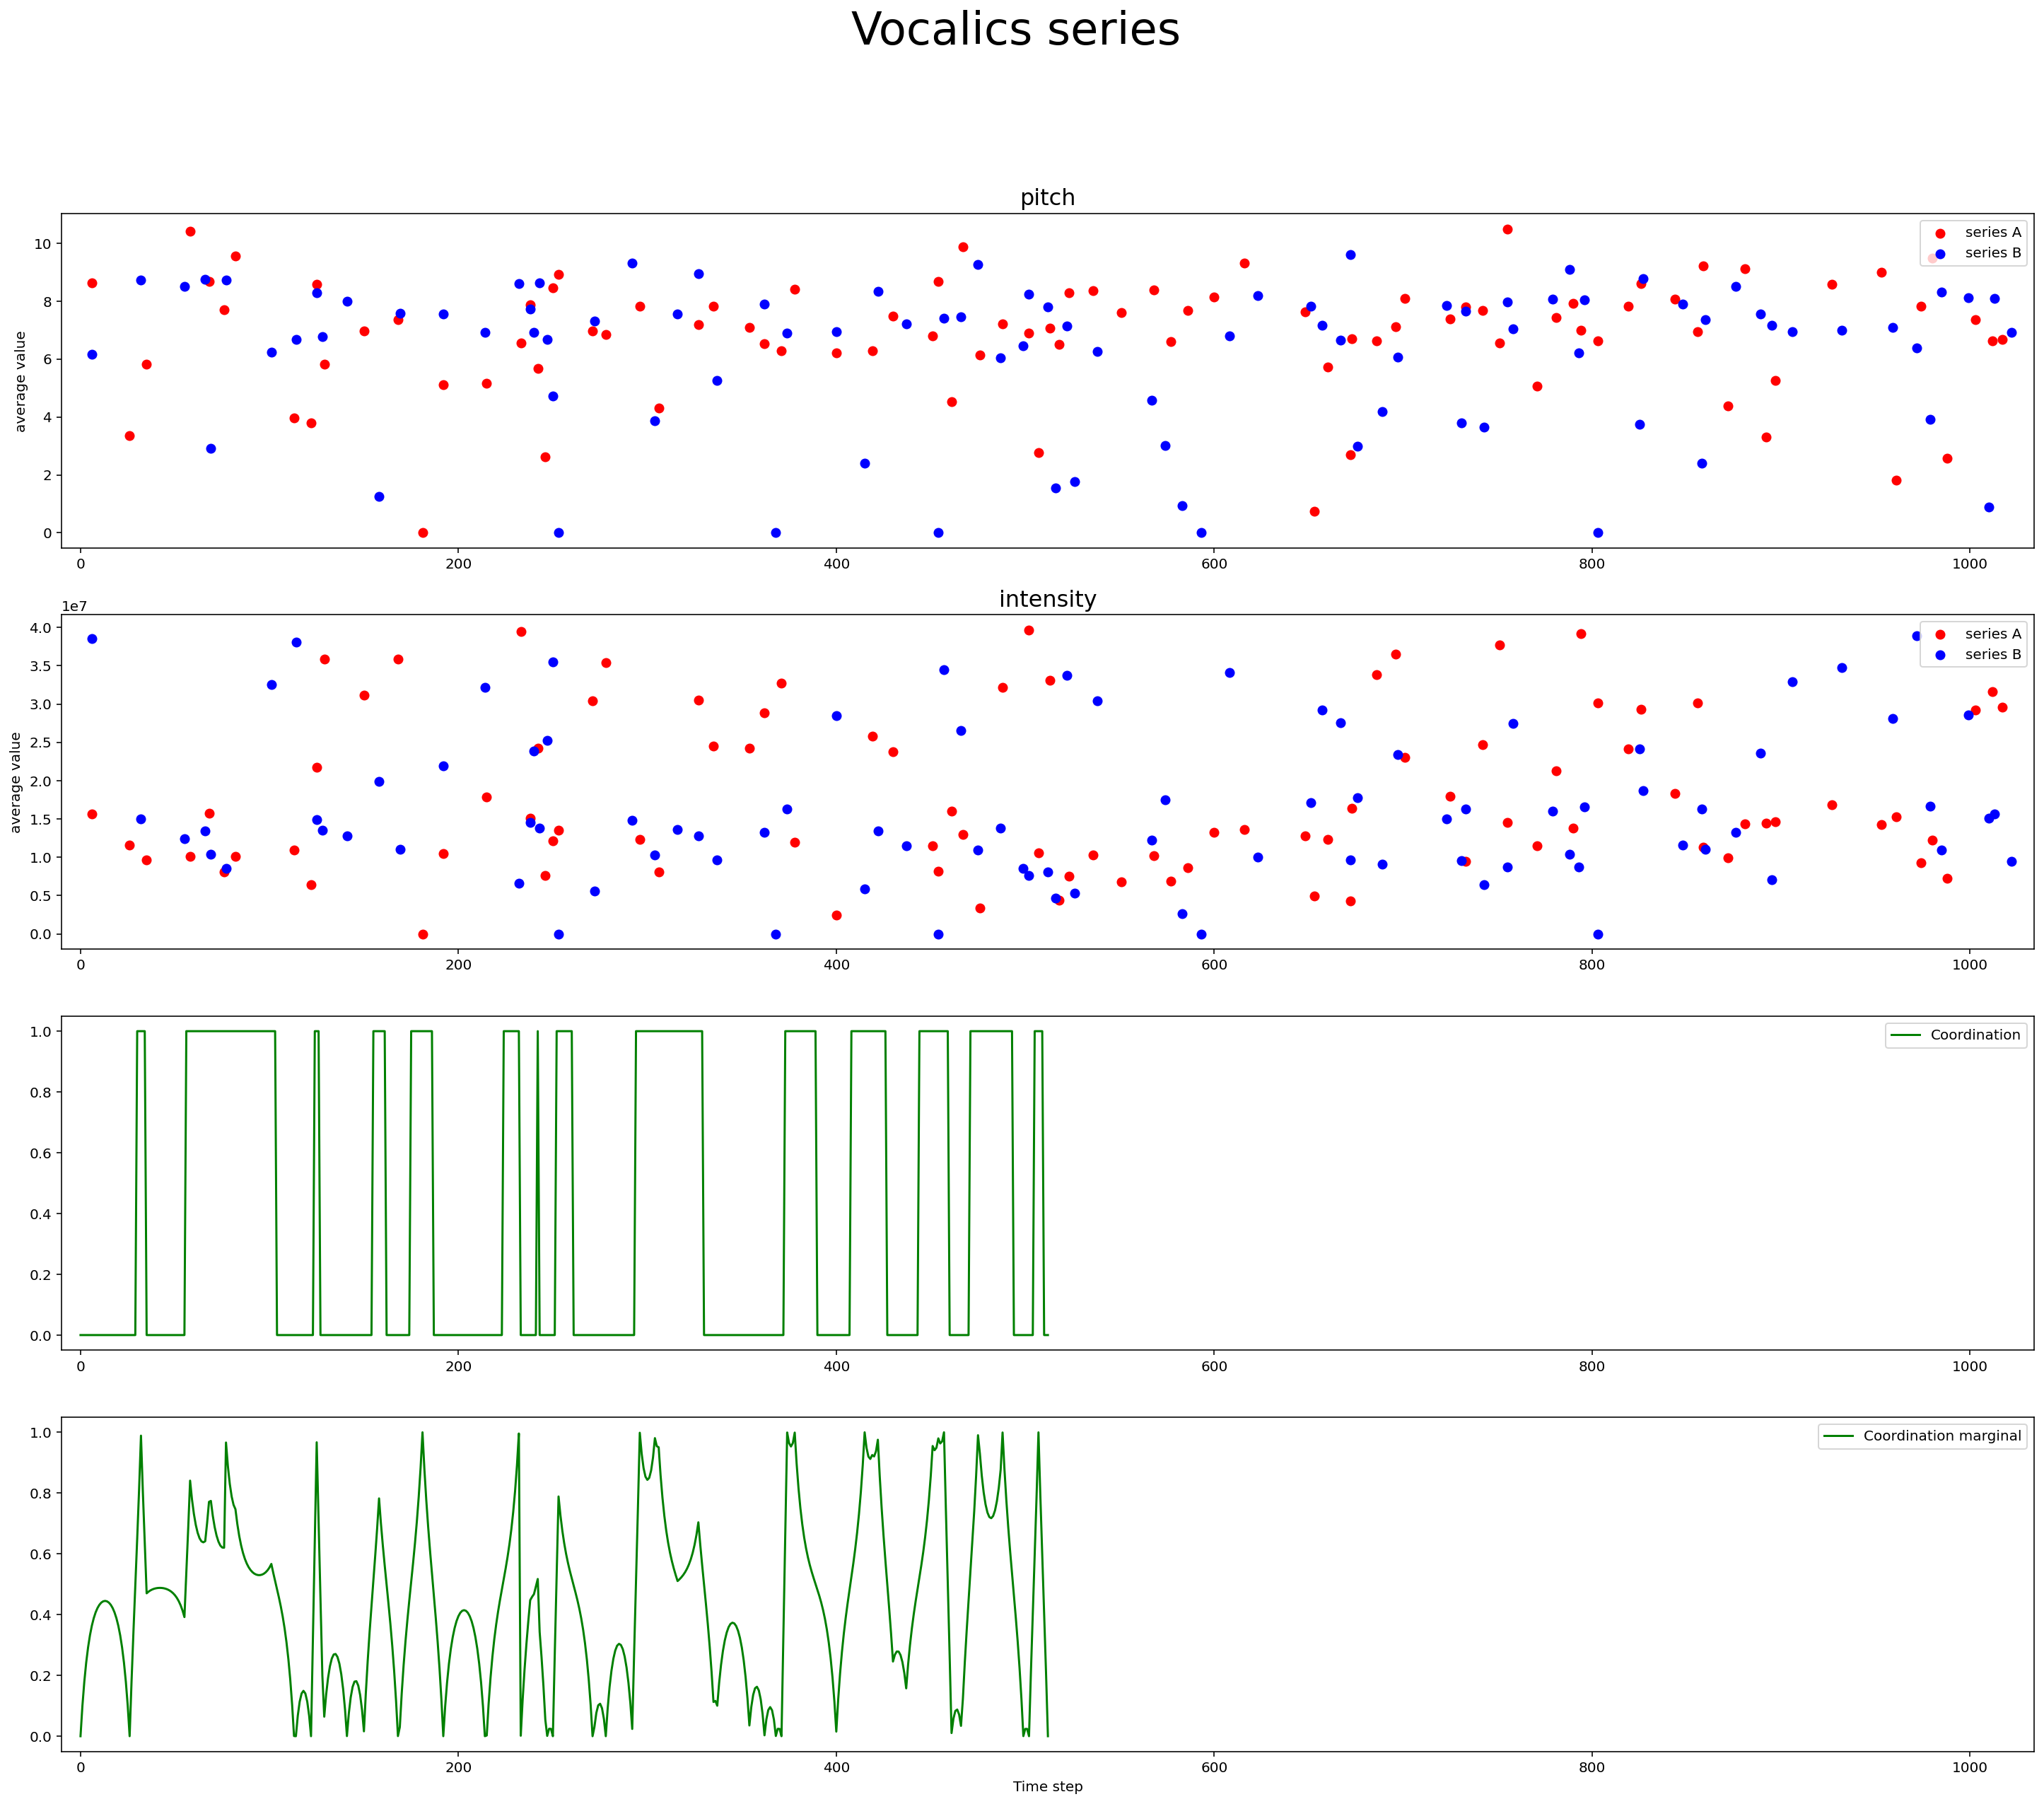

In [9]:
def plot_series_coordination(series_a, series_b, marginal_coordination, coordination):
    NUM_PLOTS = 4

    num_timestamps = None
    min_x = None
    max_x = None

    fig, axes = plt.subplots(NUM_PLOTS, figsize=(25, 20))

    for i, feature_name in enumerate(series_a.keys()):
        num_timestamps = len(series_a[feature_name])
        min_x = -10
        max_x = num_timestamps + 10

        axes[i].set_ylabel("average value")
        axes[i].set_title(feature_name, fontsize=16)
        axes[i].scatter(range(num_timestamps), series_a[feature_name], color='r', label="series A")
        axes[i].scatter(range(num_timestamps), series_b[feature_name], color='b', label="series B")
        axes[i].axis(xmin=min_x, xmax=max_x)
        axes[i].legend(loc='upper right')

    axes[2].plot(range(len(coordination)), coordination, color='g', label="Coordination")
    axes[2].axis(xmin=min_x, xmax=max_x)
    axes[2].legend(loc='upper right')

    axes[3].plot(range(len(marginal_coordination)), marginal_coordination[:, 1], color='g', label="Coordination marginal")
    axes[3].axis(xmin=min_x, xmax=max_x)
    axes[3].legend(loc='upper right')

    axes[-1].set_xlabel("Time step")

    fig.suptitle("Vocalics series", fontsize=32)

    plt.show()

plot_series_coordination(series_a, series_b, marginals, np.argmax(marginals, axis=1))

# Analyze all trials

In [10]:
trial_results = {}

for trial_number, trial_data in vocalics_series_data.items():
    series_a = trial_data["series_a"]
    series_b = trial_data["series_b"]

    num_timestamps = len(series_a["pitch"])

    multi_dim_a, mask_a = embed_features_across_dimensions(num_timestamps, series_a)
    multi_dim_b, mask_b = embed_features_across_dimensions(num_timestamps, series_b)

    # Normalize series to have mean 0 and std 1
    multi_dim_a = (multi_dim_a - np.mean(multi_dim_a, axis=0)) / np.std(multi_dim_a, axis=0)
    multi_dim_b = (multi_dim_b - np.mean(multi_dim_b, axis=0)) / np.std(multi_dim_b, axis=0)

    inference_engine = DiscreteCoordinationInference(multi_dim_a.T, multi_dim_b.T, 0, 0.9, 0, 1, 0, 1, 1, mask_a, mask_b)
    marginals = inference_engine.estimate_marginals()

    team_score = trial_data["trial_info"]["team_score"]

    trial_results[trial_number] = {
        "team_score": team_score,
        "coordinated": np.argmax(marginals[-1]),
    }

In [11]:
ordered_trial_results = {
    trial_num: trial_data for trial_num, trial_data in sorted(trial_results.items(), key=lambda trial_pair: trial_pair[1]["team_score"])
}

In [12]:
ordered_trial_results

{'T000745': {'team_score': 480, 'coordinated': 0},
 'T000746': {'team_score': 530, 'coordinated': 0}}

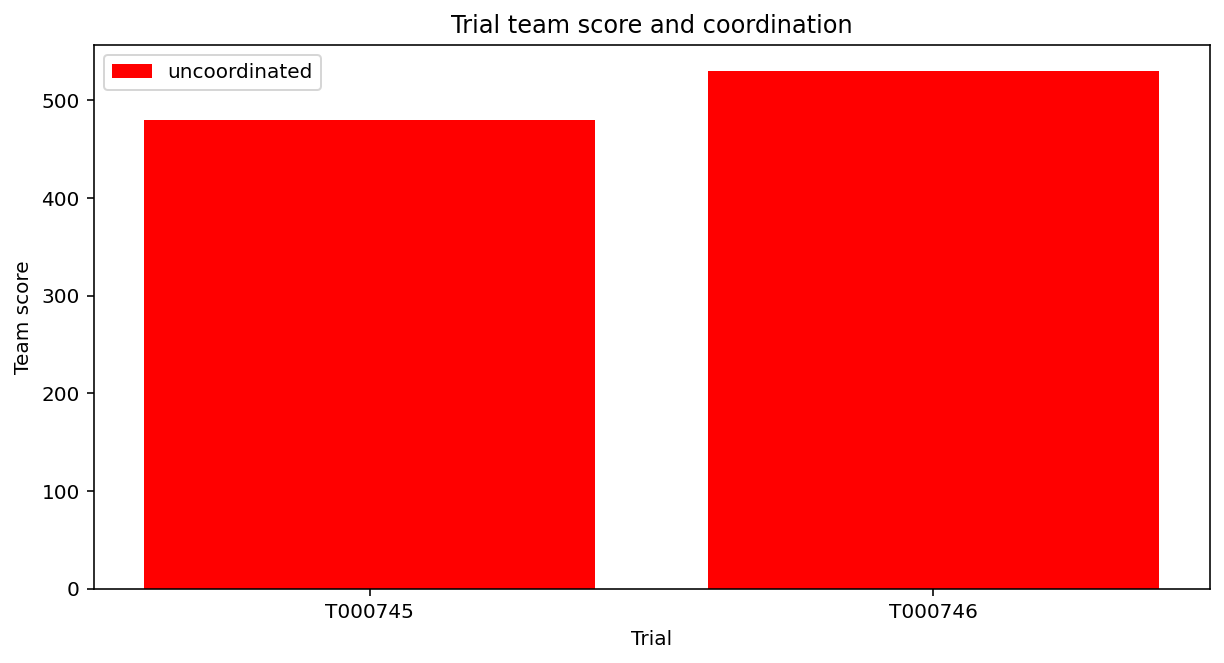

In [13]:
def plot_trial_results(trial_results):
    plt.figure(figsize = (10, 5))

    coordinated_labeled = False
    uncoordinated_labeled = False
    for trial_number, trial_result in trial_results.items():
        if trial_result["coordinated"]:
            if not coordinated_labeled:
                plt.bar(trial_number, trial_result["team_score"], color="g", label="coordinated")
                coordinated_labeled = True
            else:
                plt.bar(trial_number, trial_result["team_score"], color="g")
        else:
            if not uncoordinated_labeled:
                plt.bar(trial_number, trial_result["team_score"], color="r", label="uncoordinated")
                uncoordinated_labeled = True
            else:
                plt.bar(trial_number, trial_result["team_score"], color="r")

    plt.title("Trial team score and coordination")
    plt.xlabel("Trial")
    plt.ylabel("Team score")
    plt.legend()
    plt.show()

plot_trial_results(ordered_trial_results)